In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mlflow
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from mlflow.models import infer_signature
from mlflow.sklearn import log_model
from sklearn.preprocessing import LabelEncoder
from urllib.parse import urlparse
from sklearn.metrics import r2_score

In [23]:
data = pd.read_csv(r"C:\Users\aashutosh kumar\OneDrive\Pictures\diamonds.csv")
data.columns

Index(['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table',
       'price', 'x', 'y', 'z'],
      dtype='object')

In [24]:
data = data.drop(columns = ['Unnamed: 0'], axis =1)
data.head(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**EDA**

In [25]:
data.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [26]:
print(data.duplicated().sum())
data.drop_duplicates(inplace= True)

146


Text(0.5, 1.0, 'Distribution of carat')

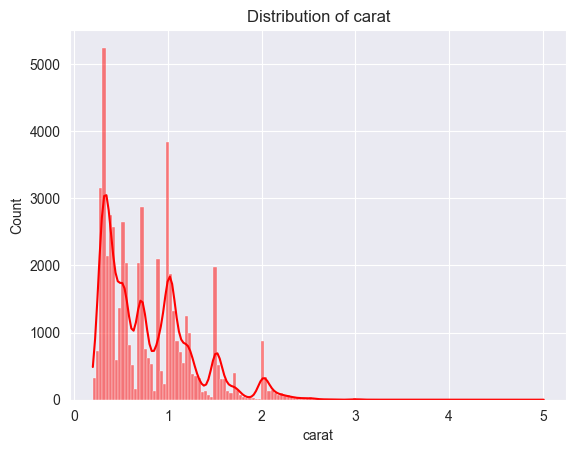

In [27]:
sns.set_style('darkgrid')
sns.histplot(data = data, x = 'carat', color = "red", kde = True)
plt.title('Distribution of carat')

Text(0.5, 1.0, 'Count of types of cut')

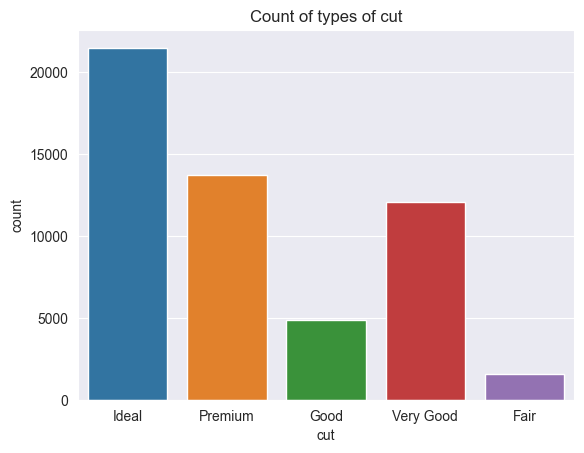

In [28]:
sns.set_style('darkgrid')
sns.countplot(data = data, x = 'cut', hue = 'cut')
plt.title('Count of types of cut')

Text(0.5, 1.0, 'Count of types of color')

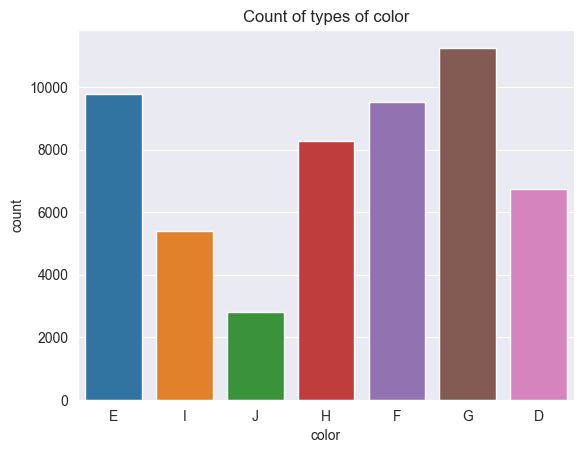

In [29]:
sns.set_style('darkgrid')
sns.countplot(data = data, x = 'color', hue = 'color')
plt.title('Count of types of color')

Text(0.5, 1.0, 'Count of types of clarity')

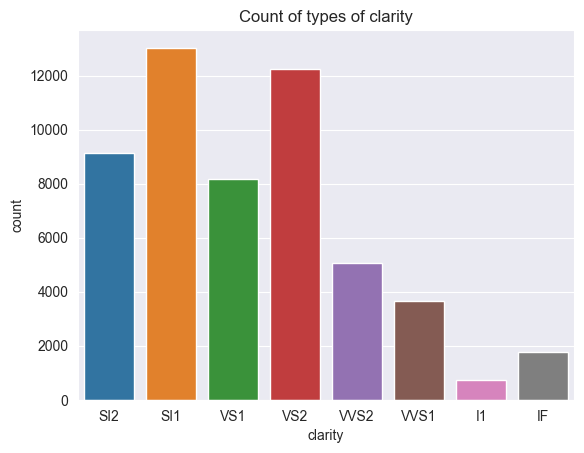

In [18]:
sns.set_style('darkgrid')
sns.countplot(data = data, x = 'clarity', hue = 'clarity')
plt.title('Count of types of clarity')

In [34]:
encoder = LabelEncoder()
data['color'] = encoder.fit_transform(data['color'])
data['clarity'] = encoder.fit_transform(data['clarity'])
data['cut'] = encoder.fit_transform(data['cut'])

In [35]:
data.head(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


<Axes: >

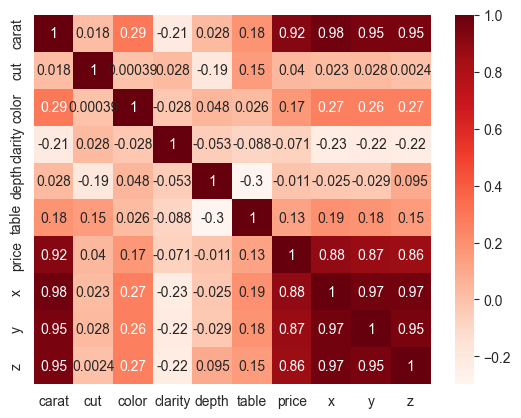

In [38]:
sns.heatmap(data = data.corr(), annot = True, cmap = "Reds")

In [39]:
data = data.drop(columns = ['cut', 'clarity', 'depth'], axis =1)
data.head(5)

,carat,color,table,price,x,y,z
0,0.23,1,55.0,326,3.95,3.98,2.43
1,0.21,1,61.0,326,3.89,3.84,2.31
2,0.23,1,65.0,327,4.05,4.07,2.31
3,0.29,5,58.0,334,4.20,4.23,2.63
4,0.31,6,58.0,335,4.34,4.35,2.75


**SPLITTING OF DATA**

In [41]:
y = data['price']
x = data.drop(columns = ['price'], axis =1)

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(43035, 6) (10759, 6) (43035,) (10759,)


In [46]:
def hyper_param_tuning(x_train, y_train, param_grid):
    rf = RandomForestRegressor()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1, cv = 3, verbose=2)
    grid_search.fit(x_train, y_train)

    return grid_search

In [48]:
signature = infer_signature(x_train, y_train)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

with mlflow.start_run():
    grid_search = hyper_param_tuning(x_train, y_train, param_grid)

    model = grid_search.best_estimator_
    y_pred = model.predict(x_test)

    r2 = r2_score(y_test, y_pred)

    mlflow.log_param("best_n_estimators",grid_search.best_params_['n_estimators'])
    mlflow.log_param("best_max_depth", grid_search.best_params_['max_depth'])
    mlflow.log_param("best_min_samples_split", grid_search.best_params_['min_samples_split'])
    mlflow.log_param("best_min_samples_leaf", grid_search.best_params_['min_samples_leaf'])
    mlflow.log_metric("r2",r2)

    mlflow.set_tracking_uri("https://127.0.0.1:5000")

    tracking_url_type_store=urlparse(mlflow.get_tracking_uri()).scheme

    if tracking_url_type_store !='file':
        mlflow.sklearn.log_model(model,"model",registered_model_name="Best Randomforest Model")
    else:
        mlflow.sklearn.log_model(model,"model",signature=signature)

    print(f"Best Hyperparameters: {grid_search.best_params_}")
    print(f"Mean Squared Error: {r2}")
    

c:\a\envs\mlflow_env\lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Fitting 3 folds for each of 24 candidates, totalling 72 fits


NameError: name 'r2_score' is not defined